In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
data_dir = 'data'
data_train = pd.read_csv(os.path.join(data_dir,'train.csv'))
data_test = pd.read_csv(os.path.join(data_dir,'test.csv'))
data_dict = pd.read_csv(os.path.join(data_dir,'data_dictionary.csv'))


### Baseline 1: Assume most common class for all

In [3]:
data_train[['sii','id']].groupby('sii',as_index=False).count()

,sii,id
0,0.0,1594
1,1.0,730
2,2.0,378
3,3.0,34


Most common SII value is 0.

In [4]:
def baseline_mode(X):
    return np.zeros(X.shape[0])

In [5]:
train_acc = np.mean(baseline_mode(data_train) == data_train['sii'].values)
print('Training accuracy:',train_acc)
print('Submit to Kaggle to get test accuracy!!!')

Training accuracy: 0.4025252525252525
Submit to Kaggle to get test accuracy!!!


### Baseline 2: Regress on Age

In [6]:
data = data_train[['sii','Basic_Demos-Age','PCIAT-PCIAT_Total']].dropna()
data

,sii,Basic_Demos-Age,PCIAT-PCIAT_Total
0,2.0,5,55.0
1,0.0,9,0.0
2,0.0,10,28.0
3,1.0,9,44.0
5,1.0,13,34.0
...,...,...,...
3953,0.0,8,22.0
3954,1.0,7,33.0
3955,1.0,13,32.0
3957,1.0,11,31.0


In [7]:
X = data[['Basic_Demos-Age']].values.reshape((-1,1))
y = data[['PCIAT-PCIAT_Total']]

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(
    units=1,                     # output dim
    input_shape=[1],             # input dim
    use_bias=True,               # use a bias (intercept) param
    kernel_initializer=tf.ones_initializer,  # initialize params to 1
    bias_initializer=tf.ones_initializer,    # initialize bias to 1
))

# We need to choose an optimizer. We'll use SGD, which is actually mini-batch GD
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)

# Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
model.compile(
optimizer=optimizer,
loss=tf.keras.losses.MeanSquaredError(),
metrics=[tf.keras.metrics.Accuracy()]
)


In [9]:
num_epochs=10
model.fit(
    x=X,      # feature data
    y=y,      # outcome data
    epochs=num_epochs,  # number of epochs
)

Epoch 1/10
86/86 [==============================] - 0s 388us/step - loss: 420.2577 - accuracy: 3.6550e-04
Epoch 2/10
86/86 [==============================] - 0s 329us/step - loss: 346.0789 - accuracy: 0.0000e+00
Epoch 3/10
 1/86 [..............................] - ETA: 0s - loss: 430.2373 - accuracy: 0.0000e+00

2024-11-18 20:17:24.457176: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


86/86 [==============================] - 0s 324us/step - loss: 344.8321 - accuracy: 0.0000e+00
Epoch 4/10
86/86 [==============================] - 0s 315us/step - loss: 344.8449 - accuracy: 0.0000e+00
Epoch 5/10
86/86 [==============================] - 0s 693us/step - loss: 344.7549 - accuracy: 0.0000e+00
Epoch 6/10
86/86 [==============================] - 0s 319us/step - loss: 344.7285 - accuracy: 0.0000e+00
Epoch 7/10
86/86 [==============================] - 0s 324us/step - loss: 344.5950 - accuracy: 0.0000e+00
Epoch 8/10
86/86 [==============================] - 0s 315us/step - loss: 344.8186 - accuracy: 0.0000e+00
Epoch 9/10
86/86 [==============================] - 0s 292us/step - loss: 344.7815 - accuracy: 0.0000e+00
Epoch 10/10
86/86 [==============================] - 0s 305us/step - loss: 344.7944 - accuracy: 0.0000e+00


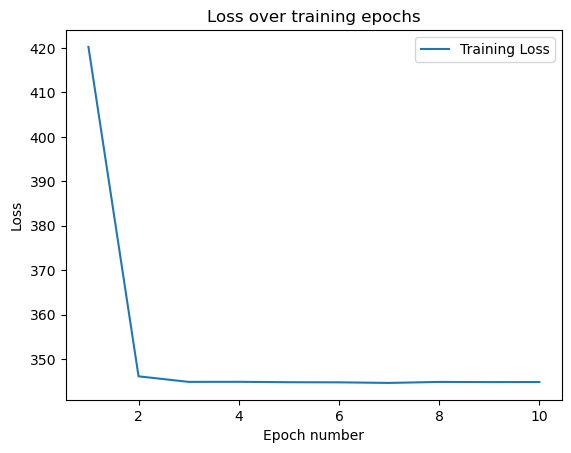

In [10]:
plt.style.use('default')
fig, ax = plt.subplots(1,1)
ax.plot(range(1,num_epochs+1),model.history.history['loss'],label='Training Loss')

ax.set_xlabel('Epoch number')
ax.set_ylabel('Loss')
ax.set_title('Loss over training epochs')
ax.legend()

In [11]:
(weights,bias) = model.layers[0].get_weights()
m = weights[0]
b = bias[0]
print('Slope:',m)
print('Bias:',b)

Slope: [2.5886476]
Bias: 1.1718167


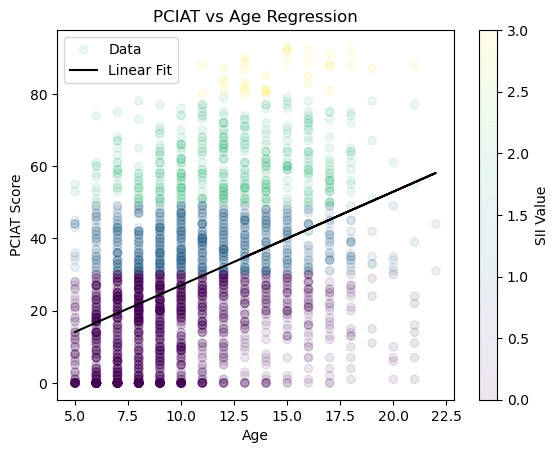

In [12]:
plt.style.use('default')
fig, ax = plt.subplots(1,1)
sc = ax.scatter(X,y,alpha=0.1,c=data['sii'],label='Data')
ax.plot(X,m*X+b,label='Linear Fit',c='k')
cb = fig.colorbar(sc)
cb.set_label('SII Value')

ax.set_xlabel('Age')
ax.set_ylabel('PCIAT Score')
ax.set_title('PCIAT vs Age Regression')
ax.legend()

plt.show()

In [13]:
def baseline_age(X):
    pciat = np.round(2.5886476*X + 1.1718167)

    sii = 3*np.ones(X.shape)
    sii[pciat < 80] = 2
    sii[pciat < 50] = 1
    sii[pciat < 31] = 0

    return sii


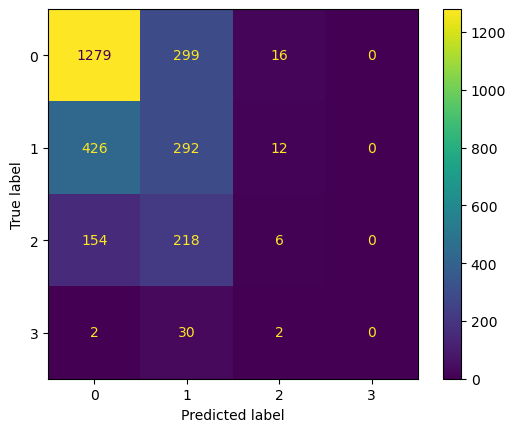

In [14]:
y_pred_train = baseline_age(X)

cm = confusion_matrix(data[['sii']].values,y_pred_train)

cm_dist = ConfusionMatrixDisplay(cm)
cm_dist.plot()
plt.show()

In [15]:
train_acc = np.mean(baseline_age(data_train['Basic_Demos-Age'].values) == data_train['sii'].values)
print('Training accuracy:',train_acc)
print('Submit to Kaggle to get test accuracy!!!')

Training accuracy: 0.3982323232323232
Submit to Kaggle to get test accuracy!!!


### Baseline 3: Regress on Age and Sex

In [16]:
data = data_train[['sii','Basic_Demos-Age','Basic_Demos-Sex','PCIAT-PCIAT_Total']].dropna()
data

,sii,Basic_Demos-Age,Basic_Demos-Sex,PCIAT-PCIAT_Total
0,2.0,5,0,55.0
1,0.0,9,0,0.0
2,0.0,10,1,28.0
3,1.0,9,0,44.0
5,1.0,13,1,34.0
...,...,...,...,...
3953,0.0,8,0,22.0
3954,1.0,7,1,33.0
3955,1.0,13,0,32.0
3957,1.0,11,0,31.0


In [17]:
X = data[['Basic_Demos-Age','Basic_Demos-Sex']].values.reshape((-1,2))
y = data[['PCIAT-PCIAT_Total']]

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(
    units=1,                     # output dim
    input_shape=[2],             # input dim
    use_bias=True,               # use a bias (intercept) param
    kernel_initializer=tf.ones_initializer,  # initialize params to 1
    bias_initializer=tf.ones_initializer,    # initialize bias to 1
))

# We need to choose an optimizer. We'll use SGD, which is actually mini-batch GD
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)

# Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
model.compile(
optimizer=optimizer,
loss=tf.keras.losses.MeanSquaredError(),
metrics=[tf.keras.metrics.Accuracy()]
)


In [19]:
num_epochs=10
model.fit(
    x=X,      # feature data
    y=y,      # outcome data
    epochs=num_epochs,  # number of epochs
)

Epoch 1/10
86/86 [==============================] - 0s 385us/step - loss: 419.6533 - accuracy: 0.0000e+00
Epoch 2/10
86/86 [==============================] - 0s 328us/step - loss: 348.4652 - accuracy: 0.0000e+00
Epoch 3/10
86/86 [==============================] - 0s 307us/step - loss: 347.2029 - accuracy: 0.0000e+00
Epoch 4/10
86/86 [==============================] - 0s 309us/step - loss: 347.1649 - accuracy: 0.0000e+00
Epoch 5/10
86/86 [==============================] - 0s 324us/step - loss: 347.0161 - accuracy: 0.0000e+00
Epoch 6/10
86/86 [==============================] - 0s 312us/step - loss: 346.9326 - accuracy: 0.0000e+00
Epoch 7/10
86/86 [==============================] - 0s 303us/step - loss: 346.7379 - accuracy: 0.0000e+00
Epoch 8/10
86/86 [==============================] - 0s 294us/step - loss: 346.9089 - accuracy: 0.0000e+00
Epoch 9/10
86/86 [==============================] - 0s 301us/step - loss: 346.8142 - accuracy: 0.0000e+00
Epoch 10/10
86/86 [===========================

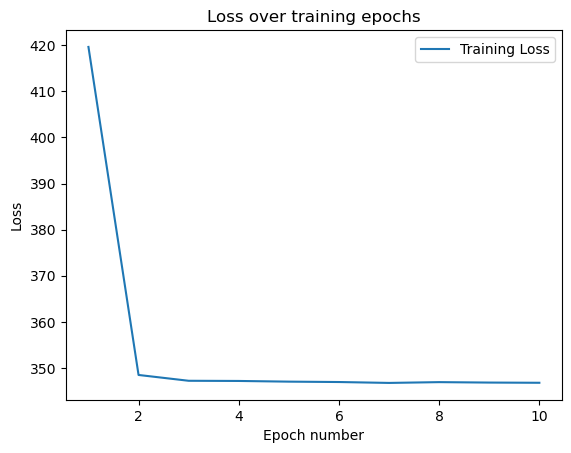

In [20]:
plt.style.use('default')
fig, ax = plt.subplots(1,1)
ax.plot(range(1,num_epochs+1),model.history.history['loss'],label='Training Loss')

ax.set_xlabel('Epoch number')
ax.set_ylabel('Loss')
ax.set_title('Loss over training epochs')
ax.legend()

In [21]:
(weights,bias) = model.layers[0].get_weights()
m1 = weights[0][0]
m2 = weights[1][0]
b = bias[0]
print('Slope (age):',m1)
print('Slope (sex):',m2)
print('Bias:',b)

Slope (age): 2.56201
Slope (sex): 0.8274159
Bias: 1.1648711


In [22]:
# TODO: pred/actual plot

In [23]:
def baseline_age_sex(X):
    pciat = np.round(2.56201*X[:,0] + 0.8274159*X[:,1] + 1.1648711)

    sii = 3*np.ones(X.shape[0])
    sii[pciat < 80] = 2
    sii[pciat < 50] = 1
    sii[pciat < 31] = 0

    return sii


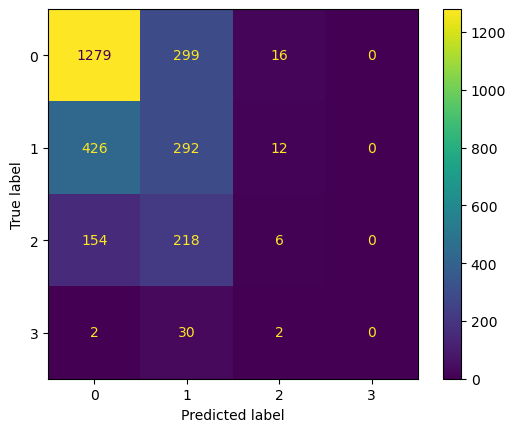

In [24]:
y_pred_train = baseline_age_sex(X)

cm = confusion_matrix(data[['sii']].values,y_pred_train)

cm_dist = ConfusionMatrixDisplay(cm)
cm_dist.plot()
plt.show()

In [25]:
train_acc = np.mean(baseline_age_sex(data_train[['Basic_Demos-Age','Basic_Demos-Sex']].values) == data_train['sii'].values)
print('Training accuracy:',train_acc)
print('Submit to Kaggle to get test accuracy!!!')

Training accuracy: 0.3982323232323232
Submit to Kaggle to get test accuracy!!!


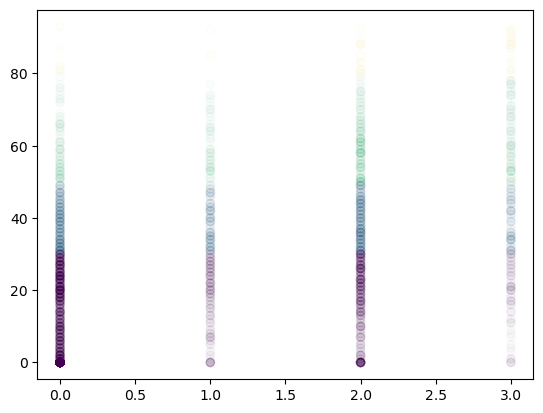

In [26]:
fig,ax = plt.subplots(1,1)
ax.scatter(data_train['PreInt_EduHx-computerinternet_hoursday'],data_train['PCIAT-PCIAT_Total'],c=data_train.sii,alpha=0.02)

In [27]:
data_train.shape

(3960, 82)

In [28]:
tmp = data_train[['sii','PreInt_EduHx-computerinternet_hoursday']].dropna(subset='sii').fillna(0)
tmp.shape

(2736, 2)

In [29]:
np.mean(tmp['PreInt_EduHx-computerinternet_hoursday'] == tmp.sii)

0.4652777777777778